In [1]:
"""
torch modules
with ofc  numpy  and pandas

"""

import pandas as pd
import numpy as np 

from torch import nn
import torch
from torchtext import data
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 

  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

import random
SEED= 32


import re
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.ar import Arabic
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

gpu up


In [2]:
!pip show torch


Name: torch
Version: 1.7.1+cu110
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, typing-extensions
Required-by: torchvision, torchtext, torchmetrics, torchaudio, pytorch-lightning, pytorch-ignite, kornia, fastai, fairscale, easyocr, catalyst, allennlp


In [3]:
"""
regex and the tokenizers
"""

'\nregex and the tokenizers\n'

In [4]:
df = pd.read_csv("../input/ipa-data-bangla/sushmitIPAData.csv",delimiter="\t",names=["ban","ipa"])

In [5]:
df

,ban,ipa
0,ও,o
1,করে,kɔre
2,না,na
3,থেকে,t̪ʰeke
4,এ,e
...,...,...
179316,সেটির,ʃetir
179317,মহলের,mɔholer
179318,বর্ষণ,bɔrʃon
179319,উঠলে,utʰle


In [6]:

def myTokenizerBAN(x):
    x = ' '.join(x)
    x = x.split(' ')
    return list(x)

def myTokenizerIPA(x):
    x = ' '.join(x)
    x = x.split(' ')
    return list(x)


SRC = data.Field(tokenize=myTokenizerBAN,batch_first=False,init_token="<sos>",eos_token="<eos>")
TARGET = data.Field(tokenize=myTokenizerIPA,batch_first=False,tokenizer_language="ipa",init_token="<sos>",eos_token="<eos>")

class DataFrameDataset(data.Dataset):

    def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
        fields = [('ban', src_field), ('ipa',target_field)]
        examples = []
        for i, row in df.iterrows():
            ban = row.ban 
            ipa = row.ipa
            examples.append(data.Example.fromlist([ban, ipa], fields))

        super().__init__(examples, fields, **kwargs)

        
torchdataset = DataFrameDataset(df,SRC,TARGET)

train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(SEED))

SRC.build_vocab(train_data,min_freq=2)
TARGET.build_vocab(train_data,min_freq=2)

BATCH_SIZE = 64



train_iterator,valid_iterator = data.BucketIterator.splits(
    (train_data,valid_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort=False,
    sort_within_batch=False,
shuffle=True)


/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information

In [7]:
"""
to point out one thing about the transformer what it could do is to enable 
training on the whole sequence at once but on really using it for translation it predicts the next word 
then it feeds the prediction into the sequence again until the model predict <eos> token (with a max length ofc)

"""
class TranslateTransformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        max_len,
    ):
        super(TranslateTransformer, self).__init__()
        self.srcEmbeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.trgEmbeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.srcPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.trgPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.src_pad_idx = src_pad_idx
        self.max_len = max_len
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask.to(device)

    def forward(self,x,trg):
        src_seq_length = x.shape[0]
        N = x.shape[1]
        trg_seq_length = trg.shape[0]
        #adding zeros is an easy way
        src_positions = (
            torch.arange(0, src_seq_length)
            .reshape(src_seq_length,1)  + torch.zeros(src_seq_length,N) 
        ).to(device)
        
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .reshape(trg_seq_length,1)  + torch.zeros(trg_seq_length,N) 
        ).to(device)


        srcWords = self.dropout(self.srcEmbeddings(x.long()) +self.srcPositionalEmbeddings(src_positions.long()))
        trgWords = self.dropout(self.trgEmbeddings(trg.long())+self.trgPositionalEmbeddings(trg_positions.long()))
        
        src_padding_mask = self.make_src_mask(x)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)
        
        
        out = self.transformer(srcWords,trgWords, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)
        return out
        



In [8]:
#No. of unique tokens in text
src_vocab_size  = len(SRC.vocab)
print("Size of Bangla vocabulary:",src_vocab_size)

#No. of unique tokens in label
trg_vocab_size =len(TARGET.vocab)
print("Size of IPA vocabulary:",trg_vocab_size)

num_heads = 8
num_encoder_layers = 2
num_decoder_layers = 2

max_len= 100
embedding_size= 256
src_pad_idx =SRC.vocab.stoi["<pad>"]


model = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

Size of Bangla vocabulary: 70
Size of IPA vocabulary: 34


In [9]:
loss_track = []
loss_validation_track= []

In [10]:
"""
I'm using adagrad because it assigns bigger updates to less frequently updated weights so 
so thought it could be useful for words not used a lot 
"""

optimizer = optim.Adagrad(model.parameters(),lr = 0.003)
EPOCHS = 100


pad_idx = SRC.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx) 

for i in range(0,EPOCHS):
    stepLoss=[]
    model.train() # the training mode for the model (applies dropout and batchnorms)
    for batch  in train_iterator:
        input_sentence = batch.ban.to(device)
        trg = batch.ipa.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)
        
        
        loss.backward()
        optimizer.step()
        stepLoss.append(loss.item())
        

    loss_track.append(np.mean(stepLoss))
    print("train crossentropy at epoch {} loss: ".format(i),np.mean(stepLoss))
    
    stepValidLoss=[]
    model.eval() # the evaluation mode for the model (doesn't apply dropout and batchNorm)
    for batch  in valid_iterator:
        input_sentence = batch.ban.to(device)
        trg = batch.ipa.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg) #+ torch.norm(out - trg)
        
        stepValidLoss.append(loss.item())
  
    loss_validation_track.append(np.mean(stepValidLoss))
    print("validation crossentropy at epoch {} loss: ".format(i),np.mean(stepValidLoss))
    
    
        

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


train crossentropy at epoch 0 loss:  0.366098124377702
validation crossentropy at epoch 0 loss:  0.10381165990828406
train crossentropy at epoch 1 loss:  0.1219342910102257
validation crossentropy at epoch 1 loss:  0.08679858395255398
train crossentropy at epoch 2 loss:  0.10368049543859383
validation crossentropy at epoch 2 loss:  0.080119845263142
train crossentropy at epoch 3 loss:  0.09478889664603492
validation crossentropy at epoch 3 loss:  0.07716589894165649
train crossentropy at epoch 4 loss:  0.08926656988950366
validation crossentropy at epoch 4 loss:  0.07397104660962142
train crossentropy at epoch 5 loss:  0.08455073922360773
validation crossentropy at epoch 5 loss:  0.07185130827660123
train crossentropy at epoch 6 loss:  0.08182460718840547
validation crossentropy at epoch 6 loss:  0.07015476253634043
train crossentropy at epoch 7 loss:  0.0791000007326905
validation crossentropy at epoch 7 loss:  0.06912038302291416
train crossentropy at epoch 8 loss:  0.076880387087036

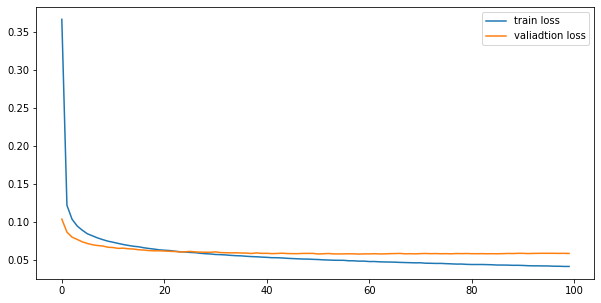

In [11]:
import matplotlib.pyplot as plt 

#the train loss after 50 epoch
plt.figure(figsize=(10,5))
plt.plot(range(100),loss_track,label="train loss")
plt.plot(range(100),loss_validation_track,label="valiadtion loss")
plt.legend()
plt.show()

In [12]:


def translate(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["<sos>"]
    for _ in range(60):
        
        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        outputs = torch.Tensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,outputs)
        
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue 
        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<eos>":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])
    
    

In [13]:
translate(model,"গাজীপুরের" ,SRC,TARGET,myTokenizerBAN)

'g a ɟ i p u r e r'

In [14]:
translate(model,"আমি" ,SRC,TARGET, myTokenizerBAN).replace(' ','')

'ami'

In [15]:
translate(model,"হাসপাতালের" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'haʃpat̪aler'

In [16]:
translate(model,"উপপরিদর্শক" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'upoporid̪ɔrʃok'

In [17]:
translate(model,"উপপরিদর্শকের" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'upoporid̪ɔrʃoker'

In [18]:
translate(model,"উপস্থিতি" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'upost̪ʰit̪i'

In [19]:
translate(model,"আতঙ্কিত" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'at̪ɔŋkit̪o'

In [20]:
translate(model,"তাঁদের" ,SRC,TARGET,myTokenizerBAN).replace(' ','') 


't̪ad̪er'

In [21]:
#mistake
translate(model,"গোয়েন্দা" ,SRC,TARGET,myTokenizerBAN).replace(' ','')


'goʲend̪a'

In [22]:
#mistake
translate(model,"অংশহারী" ,SRC,TARGET,myTokenizerBAN).replace(' ','')



'ɔŋʃohari'

In [23]:
def process_word(word):
    # Replace this function with your desired processing logic for each word
    print("Processing word:", word)
    ipa_converted_word = translate(model,word,SRC,TARGET,myTokenizerBAN).replace(' ','')
    print("After Conversion to IPA:", ipa_converted_word)

def traverse_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()  # Remove leading/trailing whitespace and newline characters
            process_word(word)

In [24]:
# if __name__ == "__main__":
#     file_path = "/kaggle/input/raw-words/words.txt"  # Replace with the path to your text file
#     traverse_text_file(file_path)

In [25]:
import torch

# Assuming 'model' is your translation model
torch.save(model.state_dict(), 'ipa_model.pth')


In [26]:
model_path = "/kaggle/working/ipa_model.pth"

In [27]:
class BanglaIPATranslator:
    def __init__(self, model_path):
        
        self.model = self.load_model(model_path)

    def load_model(self, model_path):
        model = TranslateTransformer(
            embedding_size,
            len(SRC.vocab),
            len(TARGET.vocab),
            SRC.vocab.stoi["<pad>"],
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            max_len
        ).to(device)
        model.load_state_dict(torch.load(model_path))
        return model

    def translate(self, sentence):
        self.model.eval()
        processed_sentence = SRC.process([myTokenizerBAN(sentence)]).to(device)
        trg = ["<sos>"]
        for _ in range(60):
            trg_indices = [TARGET.vocab.stoi[word] for word in trg]
            outputs = torch.Tensor(trg_indices).unsqueeze(1).to(device)
            outputs = self.model(processed_sentence, outputs)

            predicted_word = TARGET.vocab.itos[outputs.argmax(2)[-1:].item()]
            if predicted_word == "<unk>":
                continue
            trg.append(predicted_word)
            if predicted_word == "<eos>":
                break
        return " ".join([word for word in trg if word != "<unk>"][1:-1])



In [28]:
# Usage Example:

# Initialize the translator with the path to the saved model
translator = BanglaIPATranslator(model_path)

# Translate a Bangla word to IPA
translated_ipa = translator.translate("হাসপাতালের")
print(translated_ipa)

h a ʃ p a t ̪ a l e r


In [29]:
translate(model,"আতঙ্কিত" ,SRC,TARGET,myTokenizerBAN).replace(' ','')

'at̪ɔŋkit̪o'

as the model doesn't have a significant performance, I think it needs more epochs and much more data (maybe it needs to be bigger also but we have limited ram ) 